In [1]:
import os, sys; sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

import util.RAVDESS_dataset_util as Rd
import multimodal_vae
from train_mvae import build_model, train

from config_args import ConfigModelArgs, ConfigTrainArgs

In [3]:
cfg_model = ConfigModelArgs()
cfg_train = ConfigTrainArgs()

In [4]:
face_dataset = Rd.FaceEmotionDataset(
    root_dir=cfg_model.dataset_path,
    transform=transforms.Compose
    ([
        Rd.Rescale(cfg_model.img_size), 
        Rd.CenterCrop(cfg_model.img_size), 
        Rd.ToTensor()
    ]))

trainingset_len = len(face_dataset) // 100 * 90
testset_len = len(face_dataset) - trainingset_len
training_dataset, testing_dataset = torch.utils.data.random_split(
    face_dataset, 
    [trainingset_len, testset_len],
    #generator=torch.Generator().manual_seed(42)
)

dataset_loader = DataLoader(training_dataset, batch_size=cfg_train.batch_size,
                        shuffle=True, num_workers=cfg_train.num_workers)

testset_loader = DataLoader(testing_dataset, batch_size=cfg_train.batch_size,
                        shuffle=True, num_workers=cfg_train.num_workers)

print('training set size: ',trainingset_len,'\ntest set size: ',testset_len)

training set size:  8820 
test set size:  1047


In [5]:
model: torch.nn.Module = build_model(
    cat_dim=cfg_model.cat_dim,
    latent_space_dim=cfg_model.z_dim,
    hidden_dim=cfg_model.hidden_dim,
    loss_weights=cfg_model.loss_weights,
    expert_type=cfg_model.expert_type,
    use_cuda=True
).double()

In [ ]:
training_losses = train(
    mvae_model=model,
    dataset_loader=dataset_loader,
    learning_rate=cfg_train.learning_rate,
    optim_betas=cfg_train.optim_betas,
    num_epochs=cfg_train.num_epochs,
    batch_size=cfg_train.batch_size,
    checkpoint_every=cfg_train.checkpoint_every,
    checkpoint_path=cfg_train.checkpoint_path,
    save_model=cfg_train.save_model,
    seed=cfg_train.seed,
    use_cuda=cfg_train.use_cuda,
    cfg=cfg_train
)

  0%|                  | 0/20 [00:00<?, ?it/s]

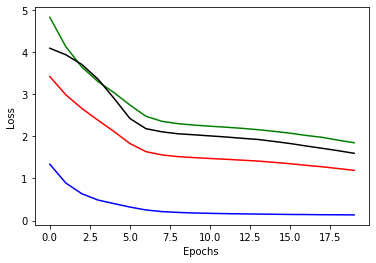

In [7]:
plt.ylabel("Loss ")
plt.xlabel("Epochs ")
plt.plot(training_losses['total_loss'], color='red')
plt.plot(training_losses['multimodal_loss'], color='green')
plt.plot(training_losses['faces_loss'], color='blue')
plt.plot(training_losses['emotions_loss'], color='black')

In [8]:
def testBatch(model, dataset_loader, img_size=64, use_cuda=True):
    sample = next(iter(dataset_loader))
    images = sample['image']
    labels = sample['cat']
    
    if use_cuda:
        images = images.cuda()
        labels = labels.cuda()
        
    input_array = np.zeros(shape=(img_size, 1, 3), dtype="uint8")
    reconstructed_array = np.zeros(shape=(img_size, 1, 3), dtype="uint8")
    reconstructed_emotions = []

    batch_size = images.shape[0]
    
    reconstructed_images, reconstructed_emotions, _, _ = model(faces=images, emotions=labels)

    for idx in range(4):
        input_image = images[idx]
        
        # storing the input image
        input_image_display = np.array(input_image.cpu()*255., dtype='uint8').transpose((1, 2, 0))
        input_array = np.concatenate((input_array, input_image_display), axis=1)
        
        # generating the reconstructed image and adding to array
        input_image = input_image.view(1, 3, img_size, img_size)
        
        reconstructed_img = reconstructed_images[idx].cpu().view(3, img_size, img_size).detach().numpy()
        reconstructed_img = np.array(reconstructed_img*255., dtype='uint8').transpose((1, 2, 0))
        reconstructed_array = np.concatenate((reconstructed_array, reconstructed_img), axis=1)
        
    # remove first, blank column, and concatenate
    input_array = input_array[:,1:,:]
    reconstructed_array = reconstructed_array[:,1:,:]
    display_array = np.concatenate((input_array, reconstructed_array), axis=0)
    plt.imshow(display_array)
    
    print([Rd.emocat[label.item()] for label in labels[:4]])
    print([Rd.emocat[emo.item()] for emo in torch.argmax(reconstructed_emotions, 1)[:4]])

['angry', 'disgust', 'happy', 'fearful']
['angry', 'disgust', 'happy', 'surprised']


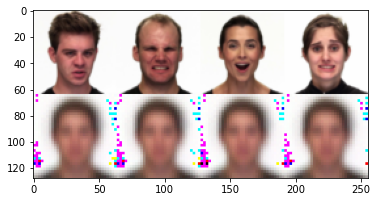

In [9]:
testBatch(model, dataset_loader)

In [10]:
from tqdm import tqdm
def emotion_accuracy(model, dataset_loader):
    
    match = 0
    total = 0
    
    for sample in tqdm(iter(dataset_loader)):
        labels = sample['cat'].cuda()
                            
        _, reconstructed_emotions, _, _ = model(faces=None, emotions=labels)  
        emotion_cat = torch.argmax(reconstructed_emotions, 1)  
        
        for idx in range(len(labels)):
            total += 1
            if labels[idx] == emotion_cat[idx]:
                match += 1
    
    acc = match / total
    return acc

In [11]:
print(emotion_accuracy(model, testset_loader))

100%|█████████| 33/33 [00:25<00:00,  1.31it/s]

0.7354345749761223
